## PPAP Neural Artistic Style Transfer

In [1]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl

In [2]:
import numpy as np
import PIL
from PIL import Image
import scipy
import theano





def cut_img(im , mode):
    h,w,_=im.shape
    if mode == "upper":
        im = im[:600,w/2-600/2:w/2+600/2]
    else:
        if mode =="middle":
            im = im[h/2-600/2:h/2+600/2, w/2-600/2:w/2+600/2]
        else:
            if mode =="low":
                im = im[h/2-600/2:h/2+600/2, w/2-600/2:w/2+600/2]
    return im
def prep_image(im):
    h, w, _ = im.shape
    if h < w:
        im = scipy.misc.imresize(im, (600, w*600/h))
    else:
        im = scipy.misc.imresize(im, (h*600/w, 600))

    
    im = cut_img(im,"upper")
    
    rawim = np.copy(im)
    rawim.astype("uint8")
    print im.shape

    im = np.swapaxes(im,0,2)
    
  
    return rawim, np.asarray(im[np.newaxis], dtype=theano.config.floatX)

(600, 600, 3)


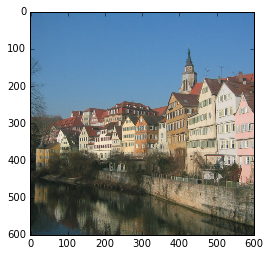

In [3]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import numpy

photo = plt.imread('1.jpg')
rawim, photo = prep_image(photo)
plt.imshow(rawim)

(600, 600, 3)


/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


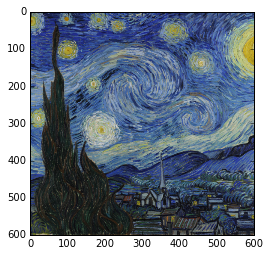

In [4]:
import matplotlib
%matplotlib inline
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image
import numpy
#art = plt.imread('36.jpg')
art = plt.imread('1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
rawim, art = prep_image(art)
plt.imshow(rawim)

In [12]:
#grad = T.grad(total_loss, generated_image)

# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
#f_grad = theano.function([], grad)
import newvgg
from newvgg import *
import pickle

import numpy
import theano.tensor as T
import math


values = pickle.load(open('vgg19_normalized.pkl'))['param values']

generated_image = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, 600, 600))))

net1 = newvgg.build_model(generated_image,numpy.random.RandomState(23455),values)
net2 = newvgg.build_model(photo,numpy.random.RandomState(23455),values)
 


# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def adam(loss, all_params, learning_rate=0.04, b1=0.9, b2=0.999, e=1e-8,
     gamma=1-1e-8):


    all_grads = T.grad(loss, all_params)
    #print all_grads
    alpha = learning_rate
    t = theano.shared(numpy.float32(1))
    b1_t = b1*gamma**(t-1)   #(Decay the first moment running average coefficient)


    m_previous =   theano.shared(numpy.zeros(all_params.get_value().shape,
                                    dtype=theano.config.floatX))
    v_previous = theano.shared(numpy.zeros(all_params.get_value().shape,
                                    dtype=theano.config.floatX))

    m = b1_t*m_previous + (1 - b1_t)*all_grads                             # (Update biased first moment estimate)
    v = b2*v_previous + (1 - b2)*all_grads**2                              # (Update biased second raw moment estimate)
    m_hat = m / (1-b1**t)                                          # (Compute bias-corrected first moment estimate)
    v_hat = v / (1-b2**t)                                          # (Compute bias-corrected second raw moment estimate)
    theta = all_params - (alpha * m_hat) / (T.sqrt(v_hat) + e) #(Update parameters)
        
    return theta


In [48]:
generated_image.set_value(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

x0 = generated_image.get_value().astype('float64')
xs = []
xs.append(x0)



total_loss = content_loss('conv4_2')
+ 1e7 * style_loss('conv1_1')
+ 1e7 * style_loss('conv2_1')
+ 1e7 * style_loss('conv3_1')
+ 1e7 * style_loss('conv4_1')
+ 1e7 * style_loss('conv5_1')
+ 1e-5 * total_variation_loss(generated_image)
newp = theano.function([], adam(total_loss, generated_image))
# updates = adam(total_loss, generated_image)
# Optimize, saving the result periodically

for i in range(5000):
    g2 = newp()
    if i%500 == 0:
        print(i)
        xs.append(g2)
    generated_image.set_value(g2)
    #x0 = generated_image.get_value().astype('float64')
    #xs.append(g2)

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [47]:
import newvgg
from newvgg import *
import pickle
import numpy
import theano.tensor as T

values = pickle.load(open('vgg19_normalized.pkl'))['param values']

generated_image = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, 600, 600))))

net1 = newvgg.build_model(generated_image,numpy.random.RandomState(23455),values)
net2 = newvgg.build_model(photo,numpy.random.RandomState(23455),values)
net3 = newvgg.build_model(art,numpy.random.RandomState(23455),values)



def content_loss(layer):
    p = net1[layer].output
    x = net2[layer].output
    
    loss = 0.5*((x - p)**2).sum()
    return loss


def style_loss(layer):
    a = net1[layer].output
    x = net3[layer].output
    #compute Gram Matrix
    A = T.tensordot(a.flatten(ndim=3), a.flatten(ndim=3), axes=([2], [2]))
    G = T.tensordot(x.flatten(ndim=3), x.flatten(ndim=3), axes=([2], [2]))
    
    loss = 1./(4 * a.shape[1]**2 * (a.shape[2]*a.shape[3])**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()



#total_loss = 1e7*style_loss('conv1_1') + 1e7 * style_loss('conv2_1') + 1e7 * style_loss('conv3_1')  + 1e7 * style_loss('conv4_1')+ 1e-5*total_variation_loss(generated_image)
#+1e7 * style_loss('conv2_1') +1e7 * style_loss('conv3_1') +1e7 * style_loss('conv4_1') + 1e-5*total_variation_loss(generated_image)
#+ 1e7 * style_loss('conv2_1')
#+ 1e7 * style_loss('conv3_1')
#+ 1e7 * style_loss('conv4_1')
#+ 1e7 * style_loss('conv5_1')
total_loss = content_loss('conv5_1') + 1e-6*total_variation_loss(generated_image)



grad = T.grad(total_loss, generated_image)
# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x):
    generated_image.set_value(floatX(x.reshape((1, 3, 600, 600))))
    return f_loss().astype('float64')

def eval_grad(x):
    generated_image.set_value(floatX(x.reshape((1, 3, 600, 600))))
    return np.array(f_grad()).flatten().astype('float64')


x = generated_image.get_value().astype('float64')


# Optimize, saving the result periodically

for i in range(8):
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x.flatten(), fprime=eval_grad, maxfun=50)
    x = generated_image.get_value().astype('float64')
    print(i)
    

0
1
2
3
4
5
6
7


In [50]:
grad = T.grad(total_loss, generated_image)
# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x):
    x = floatX(x.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x)
    return f_loss().astype('float64')

def eval_grad(x):
    x = floatX(x.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x)
    return np.array(f_grad()).flatten().astype('float64')
# Initialize with a noise image
generated_image.set_value(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

x0 = generated_image.get_value().astype('float64')
xs = []
xs.append(x0)

# Optimize, saving the result periodically
for i in range(8):
    print(i)
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=50)
    x0 = generated_image.get_value().astype('float64')
    xs.append(x0)

0
1
2
3
4
5
6
7


In [44]:
def deprocess(x):
    x = np.copy(x[0])
    x = np.swapaxes(x,0,2)    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

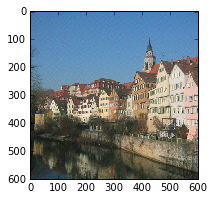

In [10]:
#total_loss = content_loss(photo_features, gen_features, 'conv1_1')
plt.figure(figsize=(3,3))
plt.imshow(deprocess(x), interpolation='nearest')

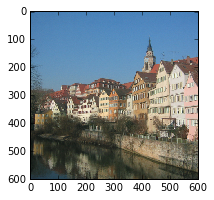

In [38]:
#total_loss = content_loss(photo_features, gen_features, 'conv2_1')
plt.figure(figsize=(3,3))
plt.imshow(deprocess(x), interpolation='nearest')

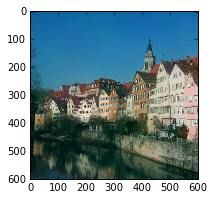

In [42]:
#total_loss = content_loss(photo_features, gen_features, 'conv3_1')
plt.figure(figsize=(3,3))
plt.imshow(deprocess(x), interpolation='nearest')

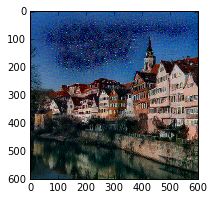

In [46]:
#total_loss = content_loss(photo_features, gen_features, 'conv4_1')
plt.figure(figsize=(3,3))
plt.imshow(deprocess(x), interpolation='nearest')

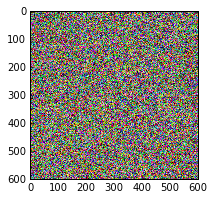

In [79]:
#total_loss = content_loss(photo_features, gen_features, 'conv5_1')
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

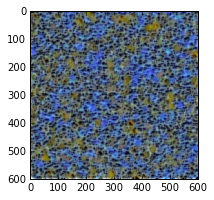

In [15]:
#total_loss = style_loss(art_features, gen_features, 'conv1_1')
plt.figure(figsize=(3,3))
plt.imshow(deprocess(x), interpolation='nearest')

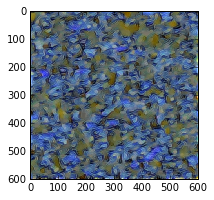

In [19]:
#total_loss = style_loss,conv1_1+conv2_1
plt.figure(figsize=(3,3))
plt.imshow(deprocess(x), interpolation='nearest')

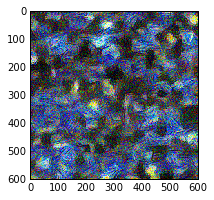

In [72]:
#total_loss = style_loss,conv1_1+conv2_1+conv3_1
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

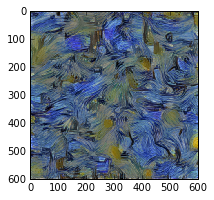

In [30]:
#total_loss = style_loss,conv1_1+conv2_1+conv3_1+conv4_1
plt.figure(figsize=(3,3))
plt.imshow(deprocess(x), interpolation='nearest')

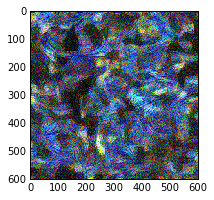

In [67]:
#total_loss = style_loss,conv1_1+conv2_1+conv3_1+conv4_1+conv5_1
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

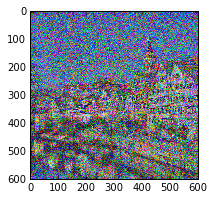

In [17]:
#total_loss = style_loss + content_loss, 1e5, no total varaition loss penalty
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

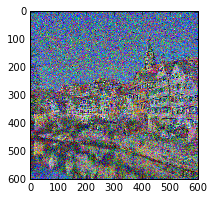

In [21]:
#total_loss = style_loss + content_loss, 1e5, 1e-6 total varaition loss penalty
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

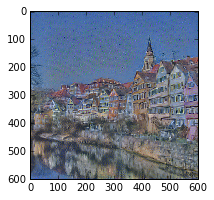

In [25]:
#total_loss = 1e5 style_loss +  content_loss, 1e-4 total varaition loss penalty
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

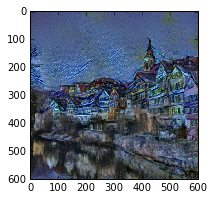

In [29]:
#total_loss = 1e7 style_loss + content_loss, 1e-4 total varaition loss penalty
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

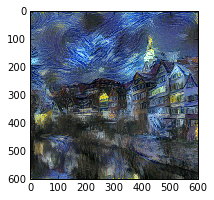

In [33]:
#total_loss = 1e8 style_loss + content_loss, 1e-4 total varaition loss penalty
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

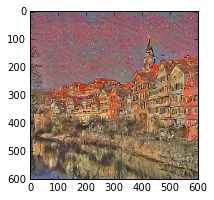

In [47]:
#total_loss = 1e5 style_loss + content_loss, 1e-4 total varaition loss penalty, Composition VII
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

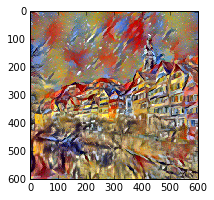

In [52]:
#total_loss = 1e7 style_loss + content_loss, 1e-4 total varaition loss penalty, Composition VII
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')

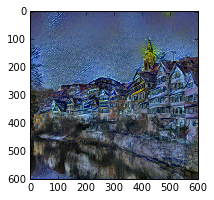

In [15]:
#total_loss = content_loss(photo_features, gen_features, 'conv1_1')
plt.figure(figsize=(3,3))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')